In [138]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch
import torchvision
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [139]:
training = torchvision.datasets.FashionMNIST(root="./", train=True, download=True)
train_loader = torch.utils.data.DataLoader(training,shuffle=True)

testing = torchvision.datasets.FashionMNIST(root="./", train=False, download=True, 
                                            transform=torchvision.transforms.Normalize((0), (1.0)))
testing_loader = torch.utils.data.DataLoader(testing, shuffle=True)

In [140]:
print(train_loader.dataset.data.size())
print(train_loader.dataset.classes)

torch.Size([60000, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


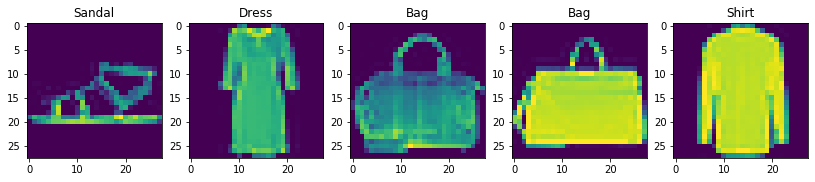

In [141]:
n_items = train_loader.dataset.data.size()[0]
random_items = np.random.choice(np.arange(n_items), 5)

plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    item  = random_items[i]
    plt.imshow(train_loader.dataset.data[item])
    plt.title(train_loader.dataset.classes[train_loader.dataset.targets[item]] )

In [142]:
train  = train_loader.dataset.data[:600].float()
y_train = train_loader.dataset.targets[:600].float()

test  = train_loader.dataset.data[600:1200].float()
y_test = train_loader.dataset.targets[600:1200].float()

mean = train.mean(dim=0)
std = train.std(dim=0)
std[std==0]=1.0

for i in range(len(train)):
    train[i] = (train[i]-mean)/std

mean = test.mean(dim=0)
std = test.std(dim=0)
std[std==0]=1.0

for i in range(len(test)):
    test[i] = (test[i]-mean)/std

print(np.shape(train))

torch.Size([600, 28, 28])


In [143]:
x_train = train.unsqueeze(1)
x_test = test.unsqueeze(1)
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

torch.Size([600, 1, 28, 28])
torch.Size([600])
torch.Size([600, 1, 28, 28])
torch.Size([600])


In [144]:
n = torch.nn.Conv2d(1,4,4) # in-channels = 1, out-channels = 4, kernel=4
new_tensor = n(x_train)
print(new_tensor.size())

n = torch.nn.MaxPool2d(2)
new_tensor = n(new_tensor)
print(new_tensor.size())

n = torch.nn.Conv2d(4,16,4)
new_tensor = n(new_tensor)
print(new_tensor.size())

n = torch.nn.MaxPool2d(3)
new_tensor = n(new_tensor)
print(new_tensor.size())

new_tensor = new_tensor.view(-1, 16*3*3)
print(new_tensor.size())

n = torch.nn.Linear(16*3*3,10)
new_tensor = n(new_tensor)
print(new_tensor.size())

torch.Size([600, 4, 25, 25])
torch.Size([600, 4, 12, 12])
torch.Size([600, 16, 9, 9])
torch.Size([600, 16, 3, 3])
torch.Size([600, 144])
torch.Size([600, 10])


In [145]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1,4,4),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(4,16,4),
    torch.nn.MaxPool2d(3),
    torch.nn.Flatten(1,-1),
    torch.nn.Linear(16*3*3,10)
)

out = model(x_train)
print(out.size())


torch.Size([600, 10])


In [146]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #lr: learning rate
epochs = 150
loss_arr = np.zeros(epochs)
f1_train = np.zeros(epochs)
f1_test = np.zeros(epochs)

for epoch in range(epochs):
    inputs = torch.autograd.Variable(torch.Tensor(x_train).float())
    targets = torch.autograd.Variable(torch.Tensor(y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out.squeeze(dim=1)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, y_predicted = torch.max(out.data, 1)
    loss_arr[epoch] = loss.item()
    f1_train[epoch] = sklearn.metrics.f1_score(y_train, y_predicted, average='macro')
    
    inputs_test = torch.autograd.Variable(torch.Tensor(x_test).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, y_predt = torch.max(out_test.data, 1)
    f1_test[epoch] = sklearn.metrics.f1_score(y_test, y_predt, average='macro')

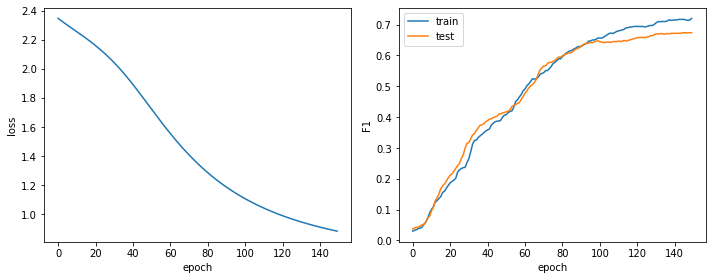

In [147]:
plt.figure(figsize = (10,4))

plt.subplot(121)
plt.plot(np.arange(epochs), loss_arr)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(np.arange(epochs), f1_train, label='train')
plt.plot(np.arange(epochs), f1_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()

plt.tight_layout()